## Mini Project: Speech Emotion Recognition Using NLP

### Problem Statement:
Many applications, like customer service bots or mental health tools, need to understand human emotions from speech. This project aims to build a system that recognizes emotions (like happiness, sadness, anger, and neutrality) from spoken words using NLP techniques. The system will analyze the text from speech and classify the emotion, helping computers interact more naturally with people.

In [1]:
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from nltk import word_tokenize, pos_tag, ne_chunk, sent_tokenize
from nltk.chunk import tree2conlltags
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download necessary nltk data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')


[nltk_data] Downloading package punkt to C:\Users\Kavya
[nltk_data]     Venkatesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kavya Venkatesh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to C:\Users\Kavya
[nltk_data]     Venkatesh\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Kavya
[nltk_data]     Venkatesh\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
# Example dummy data
data = pd.DataFrame({
    'text': [
        "I am so happy to see you!",
        "This is terrible news.",
        "I'm feeling quite sad and down.",
        "What a wonderful day!",
        "I'm really angry about this!"
    ],
    'emotion': ['happy', 'angry', 'sad', 'happy', 'angry']
})


In [3]:
def extract_nlp_features(text):
    # Sentence Tokenization
    sentences = sent_tokenize(text)

    # Word Tokenization (all tokens)
    words = word_tokenize(text)

    # POS tagging
    pos_tags = pos_tag(words)

    # NER using ne_chunk (returns tree)
    ner_tree = ne_chunk(pos_tags)
    ner_tags = tree2conlltags(ner_tree)

    # Chunking (NP chunks using RegexpParser)
    grammar = "NP: {<DT>?<JJ>*<NN>}"
    cp = nltk.RegexpParser(grammar)
    chunk_tree = cp.parse(pos_tags)

    # TextBlob sentiment
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    return {
        'sentences': sentences,
        'words': words,
        'pos_tags': pos_tags,
        'ner_tags': ner_tags,
        'chunk_tree': chunk_tree,
        'polarity': polarity,
        'subjectivity': subjectivity
    }


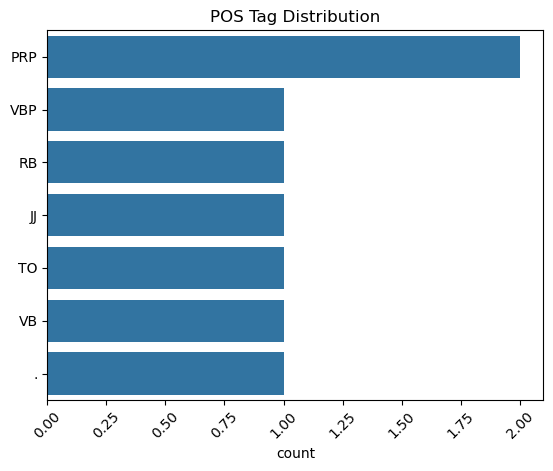

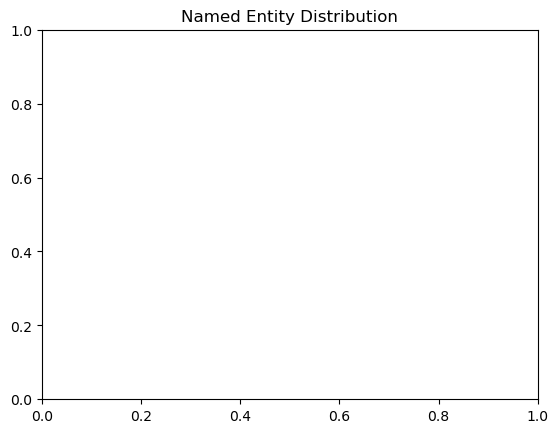

In [4]:
def visualize_pos_tags(pos_tags):
    tags = [tag for word, tag in pos_tags]
    sns.countplot(tags)
    plt.title("POS Tag Distribution")
    plt.xticks(rotation=45)
    plt.show()

def visualize_ner(ner_tags):
    entities = [tag for word, pos, tag in ner_tags if tag != 'O']
    sns.countplot(entities)
    plt.title("Named Entity Distribution")
    plt.show()

# Test on first example
features = extract_nlp_features(data.loc[0, 'text'])
visualize_pos_tags(features['pos_tags'])
visualize_ner(features['ner_tags'])


In [6]:
tfidf = TfidfVectorizer(max_features=500)
X_tfidf = tfidf.fit_transform(data['text']).toarray()


In [7]:
data['polarity'] = data['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['subjectivity'] = data['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Combine polarity and subjectivity with TF-IDF features
X_combined = np.hstack([X_tfidf, data[['polarity', 'subjectivity']].values])


In [8]:
le = LabelEncoder()
y = le.fit_transform(data['emotion'])

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


In [9]:
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

print(X_train_cnn.shape)  # e.g., (samples, features, 1)


(4, 23, 1)


In [10]:
num_classes = len(le.classes_)
input_shape = (X_train_cnn.shape[1], 1)

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


C:\Users\Kavya Venkatesh\anaconda3.n\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 21, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,987 (226.51 KB)

 Trainable params: 57,987 (226.51 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=20,
    batch_size=16
)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2500 - loss: 1.1173 - val_accuracy: 0.0000e+00 - val_loss: 1.0951
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.5000 - loss: 1.1046 - val_accuracy: 0.0000e+00 - val_loss: 1.1023
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.2500 - loss: 1.0857 - val_accuracy: 0.0000e+00 - val_loss: 1.1078
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.7500 - loss: 1.0531 - val_accuracy: 0.0000e+00 - val_loss: 1.1094
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.7500 - loss: 1.0477 - val_accuracy: 0.0000e+00 - val_loss: 1.1117
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7500 - loss: 1.0172 - val_accuracy: 0.0000e+00 - val_loss: 1.1141
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.5000 - loss: 1.0704 - val_accuracy: 0.0000e+00 - val_loss: 1.1153
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.5000 - loss: 1.0611 - val_acc

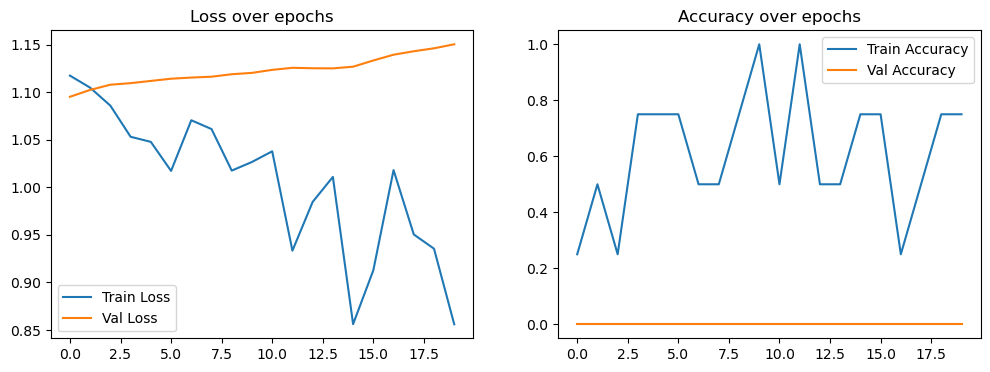

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()


C:\Users\Kavya Venkatesh\AppData\Local\Temp\ipykernel_17520\3605725251.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(tag_counts.keys()), y=list(tag_counts.values()), palette='viridis')


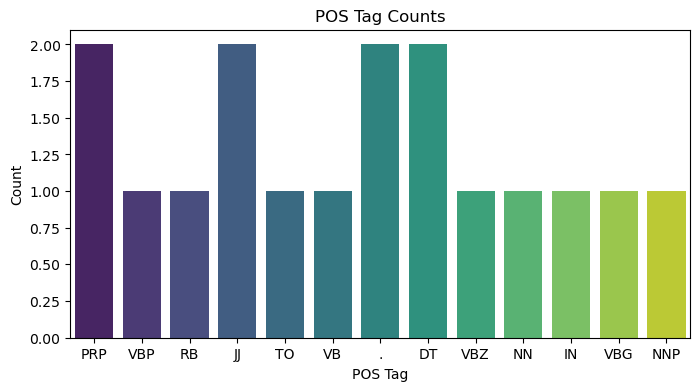

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk

def visualize_pos_tags(text):
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    tags = [tag for word, tag in pos_tags]

    tag_counts = Counter(tags)
    
    # Plot
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(tag_counts.keys()), y=list(tag_counts.values()), palette='viridis')
    plt.title("POS Tag Counts")
    plt.xlabel("POS Tag")
    plt.ylabel("Count")
    plt.show()

# Example usage:
sample_text = "I am so happy to see you! This is a great day for learning NLP."
visualize_pos_tags(sample_text)


C:\Users\Kavya Venkatesh\AppData\Local\Temp\ipykernel_17520\2379219343.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()), palette='magma')


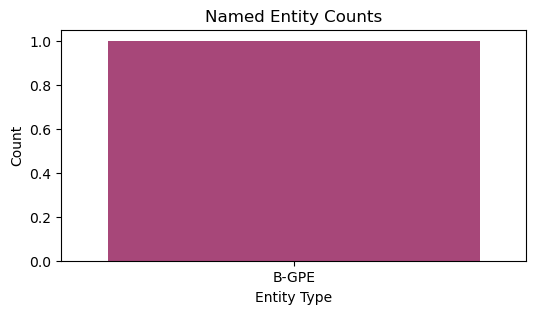

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk import pos_tag, ne_chunk, word_tokenize
from nltk.chunk import tree2conlltags

def visualize_named_entities(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    ner_tree = ne_chunk(pos_tags)
    ner_tags = tree2conlltags(ner_tree)

    # Extract only named entities (ignore 'O')
    entities = [tag for word, pos, tag in ner_tags if tag != 'O']
    entity_counts = Counter(entities)

    if not entity_counts:
        print("No named entities found.")
        return

    plt.figure(figsize=(6,3))
    sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()), palette='magma')
    plt.title("Named Entity Counts")
    plt.xlabel("Entity Type")
    plt.ylabel("Count")
    plt.show()

# Example usage:
sample_text = "Apple is looking at buying U.K. startup for $1 billion."
visualize_named_entities(sample_text)


C:\Users\Kavya Venkatesh\AppData\Local\Temp\ipykernel_17520\1622109907.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=emotion_column, data=data, palette='pastel')


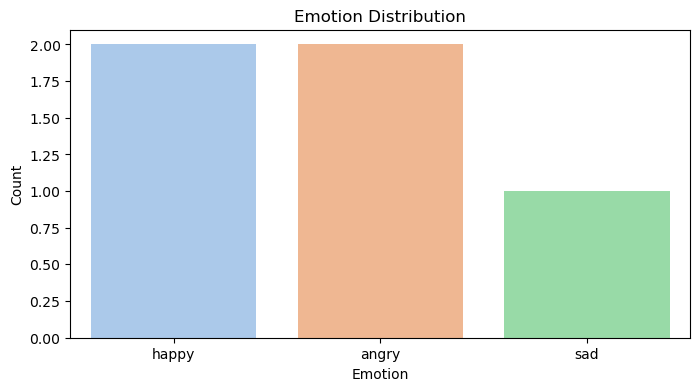

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_emotions(data, emotion_column='emotion'):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=emotion_column, data=data, palette='pastel')
    plt.title('Emotion Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()

# Example usage:
import pandas as pd

data = pd.DataFrame({
    'text': [
        "I am so happy to see you!",
        "This is terrible news.",
        "I'm feeling quite sad and down.",
        "What a wonderful day!",
        "I'm really angry about this!"
    ],
    'emotion': ['happy', 'angry', 'sad', 'happy', 'angry']
})

visualize_emotions(data)


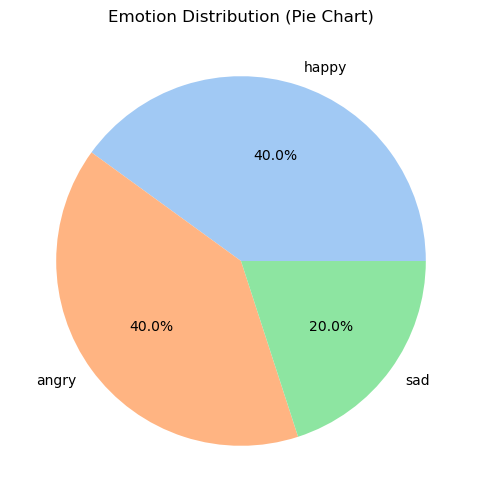

In [16]:
def visualize_emotion_pie(data, emotion_column='emotion'):
    emotion_counts = data[emotion_column].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
    plt.title("Emotion Distribution (Pie Chart)")
    plt.show()

# Usage:
visualize_emotion_pie(data)


In [17]:
# Simple mapping from emotion to emoji (Unicode)
emotion_emoji = {
    'happy': '😄',
    'sad': '😢',
    'angry': '😠',
    'neutral': '😐',
    'fear': '😨',
    'surprise': '😲',
    # add more as needed
}


In [18]:
data = pd.DataFrame({
    'text': [
        "I am so happy to see you!",
        "This is terrible news.",
        "I'm feeling quite sad and down.",
        "What a wonderful day!",
        "I'm really angry about this!"
    ],
    'emotion': ['happy', 'angry', 'sad', 'happy', 'angry']
})

for idx, row in data.iterrows():
    emo = row['emotion']
    emoji = emotion_emoji.get(emo, '❓')  # default if missing
    print(f"{emoji}  {row['text']}  [{emo}]")


😄  I am so happy to see you!  [happy]
😠  This is terrible news.  [angry]
😢  I'm feeling quite sad and down.  [sad]
😄  What a wonderful day!  [happy]
😠  I'm really angry about this!  [angry]


C:\Users\Kavya Venkatesh\AppData\Local\Temp\ipykernel_17520\2960517655.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emojis, y=counts.values, palette='Set2')


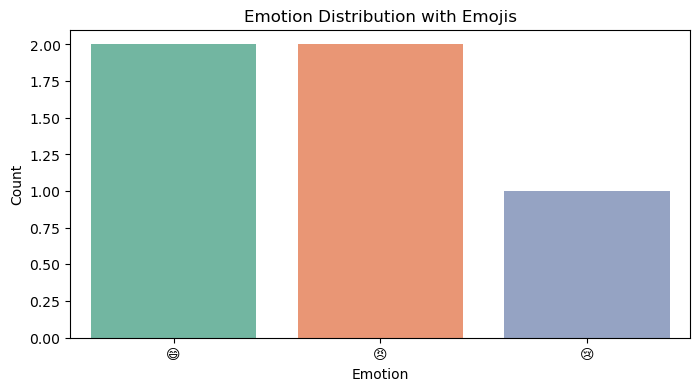

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_emotions_with_emojis(data, emotion_col='emotion'):
    counts = data[emotion_col].value_counts()
    emojis = [emotion_emoji.get(e, '❓') for e in counts.index]

    plt.figure(figsize=(8,4))
    sns.barplot(x=emojis, y=counts.values, palette='Set2')
    plt.title("Emotion Distribution with Emojis")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.show()

plot_emotions_with_emojis(data)
